In [5]:
from pyDOE2 import *
import researchpy as rp
import seaborn as sns
import numpy as np

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

from tensorflow.python.summary.summary_iterator import summary_iterator
import pandas as pd
# accuracy_table = []
# response_time_table = []


# df = pd.DataFrame({'Accuracy': accuracy_table,
#                    'Batch_size': np.repeat(['KNN', 'SVM', 'MLP'], 6),
#                    'Workloads': np.r_[np.repeat(['mushroom', 'bank', 'car', 'zoo'],2),
#                                       np.repeat(['mushroom', 'bank', 'car', 'zoo'],2),
#                                       np.repeat(['mushroom', 'bank', 'car', 'zoo'],2)]})


2022-10-31 19:08:13.331496: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
from glob import glob
import os

In [171]:
import matplotlib.pyplot as plt

In [6]:
def logs_to_pandas(path: str) -> pd.DataFrame:
    """convert single tensorflow log file to pandas DataFrame
    Parameters
    ----------
    path : str
        path to tensorflow log file
    Returns
    -------
    pd.DataFrame
        converted dataframe
    """

    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": [], "wall_time": []})
    try:
        event_acc = summary_iterator(path)
        for event in list(event_acc)[1:]:
            step, wall_time = event.step, pd.to_datetime(event.wall_time, unit='s')
            simple_extractor = [{"metric": v.tag, "value": v.simple_value, "step": step, 'wall_time': wall_time} for v in event.summary.value]
            event_r = pd.DataFrame(simple_extractor)
            runlog_data = pd.concat([runlog_data, event_r])
    # Dirty catch of DataLossError
    except Exception as e:
        print("Event file possibly corrupt: {}".format(path))
        print(e)
    return runlog_data

## Accuracy three-way ANOVA

In [158]:
accuracy_df = pd.DataFrame({"batch_size": pd.Series(dtype='category'), "epoch": pd.Series(dtype='category'), "data_parallelism": pd.Series(dtype='category'), "accuracy": pd.Series(dtype='float64')})
# accuracy_df = pd.DataFrame({"batch_size": [], "epoch": [], "data_parallelism": [], "accuracy": []})
for batch_size in [64, 128, 256]:
    for r_type in glob(f'data/{batch_size}/*'):
        for log_path in glob(os.path.join(r_type,'*.log')):
            server_log_data  = open(log_path)
            acc_avg = np.array([])
            for l in server_log_data.readlines():
                if l.find('Scheduling') >=0:
                    label = l.strip().split(' ')[-1]
                    files = glob(os.path.join(r_type, '0/cloud_experiment_'+label+'/*/*/*'))
                    for file in files:
                        log_df = logs_to_pandas(file)
                        acc_df = log_df.loc[log_df['metric'] == 'accuracy per epoch']
                        acc = acc_df.iloc[-1]['value']
                        acc_avg = np.append(acc_avg, acc)
            
            if batch_size==64 or batch_size==256:
                epoch = log_path.split('/')[-1].split('.')[0].split('-')[1]
                data_parallelism = log_path.split('/')[-1].split('.')[0].split('-')[2]
                event_df = pd.DataFrame([{"batch_size": batch_size, "epoch": epoch, "data_parallelism": data_parallelism, "accuracy": np.mean(acc_avg)}])
            elif batch_size==128:
                epoch = log_path.split('/')[-1].split('.')[0].split('_')[2].strip('ep')
                data_parallelism = log_path.split('/')[-1].split('.')[0].split('_')[1].strip('dp')
                event_df = pd.DataFrame([{"batch_size": batch_size, "epoch": epoch, "data_parallelism": data_parallelism, "accuracy": np.mean(acc_avg)}])
            accuracy_df = pd.concat([accuracy_df, event_df], ignore_index=True)
            new_df = pd.DataFrame([{"batch_size": batch_size, "epoch": epoch, "data_parallelism": data_parallelism, "accuracy": np.median(acc_avg)}])
            accuracy_df = pd.concat([accuracy_df, new_df], ignore_index=True)
            

In [159]:
final_acc_df = accuracy_df.sort_values(by=['batch_size','epoch','data_parallelism'] , ascending=(True, True, True))
final_acc_df.reset_index(drop=True, inplace=True)

In [160]:
rp.summary_cat(final_acc_df[['batch_size','epoch','data_parallelism']])

,Variable,Outcome,Count,Percent
0,batch_size,64,18,33.33
1,,128,18,33.33
2,,256,18,33.33
3,epoch,30,18,33.33
4,,35,18,33.33
5,,40,18,33.33
6,data_parallelism,2,18,33.33
7,,3,18,33.33
8,,4,18,33.33


In [161]:
rp.summary_cont(final_acc_df['accuracy'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,accuracy,54.0,87.7633,0.6602,0.0898,87.5831,87.9435


In [228]:
# Running Ols to find the anova model afterwards.
model = ols('accuracy ~ batch_size + epoch + data_parallelism + batch_size * epoch * data_parallelism', final_acc_df).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")

Overall model F( 7, 46) =  6.870, p =  0.0000


In [229]:
# Getting the final 3-way ANOVA table.
results = sm.stats.anova_lm(model, typ= 1)
results

,df,sum_sq,mean_sq,F,PR(>F)
batch_size,1.0,0.010525,0.010525,0.042862,8.368995e-01
epoch,1.0,0.267824,0.267824,1.090707,3.017721e-01
data_parallelism,1.0,9.363382,9.363382,38.132137,1.581308e-07
batch_size:epoch,1.0,1.004896,1.004896,4.092413,4.891061e-02
batch_size:data_parallelism,1.0,0.900120,0.900120,3.665714,6.177426e-02
epoch:data_parallelism,1.0,0.000542,0.000542,0.002208,9.627217e-01
batch_size:epoch:data_parallelism,1.0,0.260627,0.260627,1.061398,3.082832e-01
Residual,46.0,11.295343,0.245551,NaN,NaN


In [230]:
Sum_Square_Error = results['sum_sq'].sum()
results['Percentage_Variation_Explained'] = (results['sum_sq'] / Sum_Square_Error) * 100
results

,df,sum_sq,mean_sq,F,PR(>F),Percentage_Variation_Explained
batch_size,1.0,0.010525,0.010525,0.042862,8.368995e-01,0.045555
epoch,1.0,0.267824,0.267824,1.090707,3.017721e-01,1.159248
data_parallelism,1.0,9.363382,9.363382,38.132137,1.581308e-07,40.528403
batch_size:epoch,1.0,1.004896,1.004896,4.092413,4.891061e-02,4.349585
batch_size:data_parallelism,1.0,0.900120,0.900120,3.665714,6.177426e-02,3.896072
epoch:data_parallelism,1.0,0.000542,0.000542,0.002208,9.627217e-01,0.002347
batch_size:epoch:data_parallelism,1.0,0.260627,0.260627,1.061398,3.082832e-01,1.128098
Residual,46.0,11.295343,0.245551,NaN,NaN,48.890692


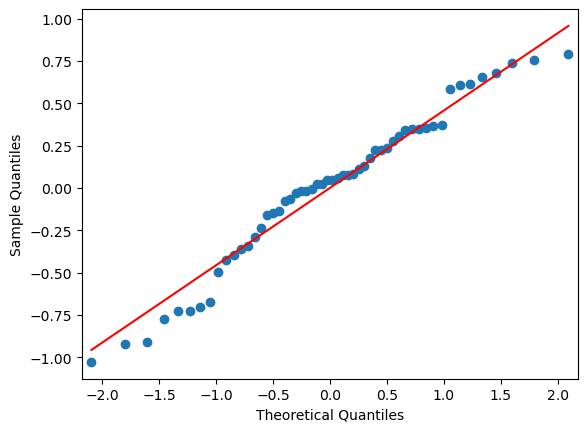

0.9646362066268921 0.11121277511119843


In [185]:

# ASSUMPTIONS CHECK.
#Check the Normal distribution of residuals
residuals = model.resid
fig = sm.qqplot(residuals, line='s')
plt.show()
fig.savefig('Residuals.png')

import scipy.stats as stats
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

In [182]:
final_acc_df['batch_size'] = final_acc_df['batch_size'].astype('float64')
final_acc_df['epoch'] = final_acc_df['epoch'].astype('float64')
final_acc_df['data_parallelism'] = final_acc_df['data_parallelism'].astype('float64')

In [227]:
import scipy.stats as stats
w, pvalue = stats.bartlett(final_acc_df.iloc[::2]['accuracy'], final_acc_df.iloc[1::2]['accuracy'])
print(w, pvalue)

0.03016886945179142 0.8621076187270947


In [231]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
variables = model.model.exog
x = results.index
print (x)
vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]

vif

Index(['batch_size', 'epoch', 'data_parallelism', 'batch_size:epoch',
       'batch_size:data_parallelism', 'epoch:data_parallelism',
       'batch_size:epoch:data_parallelism', 'Residual'],
      dtype='object')


[4861.125000000258,
 1080.2499999999927,
 65.24999999999993,
 335.2499999999991,
 1130.9999999999795,
 1341.0000000000464,
 396.00000000000614,
 1388.250000000008]

In [166]:
results.round(3).to_csv('accuracy_anova.csv')  

In [121]:
results['sum_sq'].round(3)

batch_size                           1.601
epoch                                0.755
data_parallelism                     9.596
batch_size:epoch                     2.236
batch_size:data_parallelism          3.604
epoch:data_parallelism               2.215
batch_size:epoch:data_parallelism    2.594
Residual                             0.503
Name: sum_sq, dtype: float64

In [115]:
results.to_csv('accuracy_anova.csv')  

## Response time three-way ANOVA

In [124]:
response_time_df = pd.DataFrame({"batch_size": [], "epoch": [], "data_parallelism": [], "response_time": []})
for batch_size in [64, 256]:
    for r_type in glob(f'data/{batch_size}/*'):
        for log_path in glob(os.path.join(r_type,'*.log')):
            server_log_data  = open(log_path)
            response_avg = np.array([])
            for l in server_log_data.readlines():
                if l.find('Scheduling') >=0:
                    node_arrival_times = pd.Timestamp(' '.join(l.split(' ')[0:2]))
                    label = l.strip().split(' ')[-1]
                    files = glob(os.path.join(r_type, '0/cloud_experiment_'+label+'/*/*/*'))
                    for file in files:
                        log_df = logs_to_pandas(file)
                        acc_df = log_df.loc[log_df['metric'] == 'accuracy per epoch']
                        end_times = acc_df.iloc[-1]['wall_time']
                        response_time = end_times - node_arrival_times
                        response_avg = np.append(response_avg, response_time)
            if batch_size==64 or batch_size==256:
                epoch = log_path.split('/')[-1].split('.')[0].split('-')[1]
                data_parallelism = log_path.split('/')[-1].split('.')[0].split('-')[2]
                event_df = pd.DataFrame([{"batch_size": batch_size, "epoch": epoch, "data_parallelism": data_parallelism, "response_time": np.mean(response_avg).total_seconds()}])
            elif batch_size==128:
                epoch = log_path.split('/')[-1].split('.')[0].split('_')[2].strip('ep')
                data_parallelism = log_path.split('/')[-1].split('.')[0].split('_')[1].strip('dp')
                event_df = pd.DataFrame([{"batch_size": batch_size, "epoch": epoch, "data_parallelism": data_parallelism, "response_time": np.mean(response_avg).total_seconds()}])
            response_time_df = pd.concat([response_time_df, event_df], ignore_index=True)
            new_df = pd.DataFrame([{"batch_size": batch_size, "epoch": epoch, "data_parallelism": data_parallelism, "response_time": np.median(response_avg).total_seconds()}])
            response_time_df = pd.concat([response_time_df, new_df], ignore_index=True)       


In [125]:
final_response_time_df = response_time_df.sort_values(by=['batch_size','epoch','data_parallelism'] , ascending=(True, True, True))
final_response_time_df.reset_index(drop=True, inplace=True)

In [126]:
rp.summary_cat(final_response_time_df[['batch_size','epoch','data_parallelism']])

,Variable,Outcome,Count,Percent
0,batch_size,64.0,18,50.00
1,,256.0,18,50.00
2,epoch,30,12,33.33
3,,35,12,33.33
4,,40,12,33.33
5,data_parallelism,2,12,33.33
6,,3,12,33.33
7,,4,12,33.33


In [127]:
final_response_time_df

,batch_size,epoch,data_parallelism,response_time
0,64.0,30,2,13560.609631
1,64.0,30,2,14128.707107
2,64.0,30,3,11389.452929
3,64.0,30,3,8984.512873
4,64.0,30,4,6630.680388
5,64.0,30,4,5273.205223
6,64.0,35,2,18713.620452
7,64.0,35,2,21085.910434
8,64.0,35,3,11742.383670
9,64.0,35,3,10255.415011


In [128]:
rp.summary_cont(final_response_time_df['response_time'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,response_time,36.0,10740.4132,5426.513,904.4188,8904.3454,12576.481


In [186]:
# Running Ols to find the anova model afterwards.
model = ols('response_time ~ batch_size + epoch + data_parallelism + batch_size * epoch * data_parallelism', final_response_time_df).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
# Getting the final 3-way ANOVA table.
results = sm.stats.anova_lm(model, typ= 1)
results

Overall model F( 17, 18) =  49.923, p =  0.0000


,df,sum_sq,mean_sq,F,PR(>F)
epoch,2.0,1.993647e+08,9.968234e+07,83.824842,7.571896e-10
data_parallelism,2.0,2.662881e+08,1.331441e+08,111.963457,6.987066e-11
epoch:data_parallelism,4.0,1.154148e+07,2.885369e+06,2.426364,8.564527e-02
batch_size,1.0,2.672003e+08,2.672003e+08,224.693962,1.303786e-11
batch_size:epoch,2.0,1.478280e+07,7.391399e+06,6.215573,8.863145e-03
batch_size:data_parallelism,2.0,1.314462e+08,6.572311e+07,55.267856,2.071277e-08
batch_size:epoch:data_parallelism,4.0,1.186178e+08,2.965446e+07,24.937022,3.931748e-07
Residual,18.0,2.140513e+07,1.189174e+06,NaN,NaN


In [187]:
Sum_Square_Error = results['sum_sq'].sum()
results['Percentage_Variation_Explained'] = (results['sum_sq'] / Sum_Square_Error) * 100
results

,df,sum_sq,mean_sq,F,PR(>F),Percentage_Variation_Explained
epoch,2.0,1.993647e+08,9.968234e+07,83.824842,7.571896e-10,19.343652
data_parallelism,2.0,2.662881e+08,1.331441e+08,111.963457,6.987066e-11,25.836997
epoch:data_parallelism,4.0,1.154148e+07,2.885369e+06,2.426364,8.564527e-02,1.119829
batch_size,1.0,2.672003e+08,2.672003e+08,224.693962,1.303786e-11,25.925500
batch_size:epoch,2.0,1.478280e+07,7.391399e+06,6.215573,8.863145e-03,1.434323
batch_size:data_parallelism,2.0,1.314462e+08,6.572311e+07,55.267856,2.071277e-08,12.753763
batch_size:epoch:data_parallelism,4.0,1.186178e+08,2.965446e+07,24.937022,3.931748e-07,11.509072
Residual,18.0,2.140513e+07,1.189174e+06,NaN,NaN,2.076865


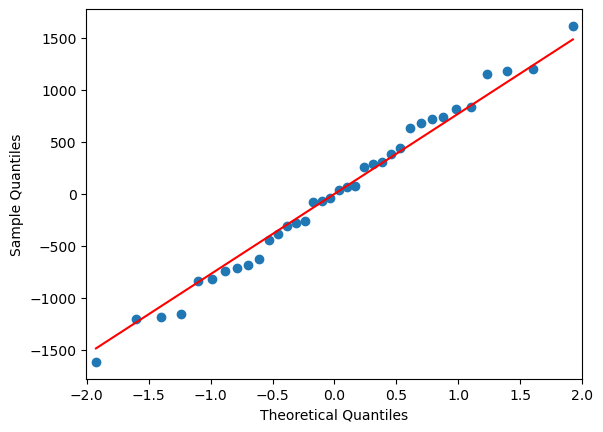

0.9862918853759766 0.9264662861824036


In [188]:

# ASSUMPTIONS CHECK.
#Check the Normal distribution of residuals
residuals = model.resid
fig = sm.qqplot(residuals, line='s')
plt.show()
fig.savefig('Residuals-response.png')

import scipy.stats as stats
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

In [212]:
final_response_time_df['batch_size'] = final_response_time_df['batch_size'].astype('float64')
final_response_time_df['epoch'] = final_response_time_df['epoch'].astype('float64')
final_response_time_df['data_parallelism'] = final_response_time_df['data_parallelism'].astype('float64')
# assumption : Homogeneity  of  variances  (variances  are  equal  between different groups) (Levene or Bartlett Test).
# batch_size * epoch * data_parallelism
import scipy.stats as stats
w, pvalue = stats.bartlett(final_response_time_df[final_response_time_df['batch_size']==64.0]['response_time'], final_response_time_df['epoch'], final_response_time_df['data_parallelism'])
print(w, pvalue)

434.0617619625525 5.555024609073951e-95


In [226]:
import scipy.stats as stats
w, pvalue = stats.bartlett(final_response_time_df.iloc[::2]['response_time'], final_response_time_df.iloc[1::2]['response_time'])
print(w, pvalue)

0.5061974445315108 0.47678960271455384


In [225]:
final_response_time_df.iloc[::2]['response_time']

0     13560.609631
2     11389.452929
4      6630.680388
6     18713.620452
8     11742.383670
10    13072.310518
12    23283.121726
14    16198.310074
16     8230.982322
18     7343.236250
20     6515.098827
22     3272.946037
24     9353.829104
26     8837.923335
28     3975.287493
30    10794.062637
32    11194.812297
34    11430.827612
Name: response_time, dtype: float64

In [221]:
from numpy.random import randn
A = [85, 86, 88, 75, 78, 94, 98, 79, 71, 80]
B = [91, 92, 93, 85, 87, 84, 82, 88, 95, 96]
C = [79, 78, 88, 94, 92, 85, 83, 85, 82, 81]
stats.bartlett(A,B,C)

BartlettResult(statistic=3.3024375753550594, pvalue=0.19181598314035977)

In [218]:
final_response_time_df[final_response_time_df['batch_size']==64.0]['response_time']

0     13560.609631
1     14128.707107
2     11389.452929
3      8984.512873
4      6630.680388
5      5273.205223
6     18713.620452
7     21085.910434
8     11742.383670
9     10255.415011
10    13072.310518
11    12449.413788
12    23283.121726
13    26513.623151
14    16198.310074
15    14938.104820
16     8230.982322
17     5915.856955
Name: response_time, dtype: float64

In [157]:
results.round(3).to_csv('response_time_anova.csv')  

In [132]:
results

,df,sum_sq,mean_sq,F,PR(>F)
epoch,2.0,1.993647e+08,9.968234e+07,83.824842,7.571896e-10
data_parallelism,2.0,2.662881e+08,1.331441e+08,111.963457,6.987066e-11
epoch:data_parallelism,4.0,1.154148e+07,2.885369e+06,2.426364,8.564527e-02
batch_size,1.0,2.672003e+08,2.672003e+08,224.693962,1.303786e-11
batch_size:epoch,2.0,1.478280e+07,7.391399e+06,6.215573,8.863145e-03
batch_size:data_parallelism,2.0,1.314462e+08,6.572311e+07,55.267856,2.071277e-08
batch_size:epoch:data_parallelism,4.0,1.186178e+08,2.965446e+07,24.937022,3.931748e-07
Residual,18.0,2.140513e+07,1.189174e+06,NaN,NaN


In [99]:
from statsmodels.formula.api import ols

final_response_time_df["Response_time"] = final_response_time_df["response_time"]

model = ols("Response_time ~ C(batch_size, Sum) + C(epoch, Sum) + C(data_parallelism, Sum) + C(batch_size, Sum)*C(epoch, Sum)*C(data_parallelism, Sum)", data=final_response_time_df).fit()

aov_table = sm.stats.anova_lm(model, typ=3)
aov_table

,sum_sq,df,F,PR(>F)
Intercept,4.152833e+09,1.0,3492.199246,4.557705e-22
"C(batch_size, Sum)",2.672003e+08,1.0,224.693962,1.303786e-11
"C(epoch, Sum)",1.993647e+08,2.0,83.824842,7.571896e-10
"C(data_parallelism, Sum)",2.662881e+08,2.0,111.963457,6.987066e-11
"C(batch_size, Sum):C(epoch, Sum)",1.478280e+07,2.0,6.215573,8.863145e-03
"C(batch_size, Sum):C(data_parallelism, Sum)",1.314462e+08,2.0,55.267856,2.071277e-08
"C(epoch, Sum):C(data_parallelism, Sum)",1.154148e+07,4.0,2.426364,8.564527e-02
"C(batch_size, Sum):C(epoch, Sum):C(data_parallelism, Sum)",1.186178e+08,4.0,24.937022,3.931748e-07
Residual,2.140513e+07,18.0,NaN,NaN


## Service time three way ANOVA

In [146]:
service_time_df = pd.DataFrame({"batch_size": [], "epoch": [], "data_parallelism": [], "service_time": []})
for batch_size in [64, 128, 256]:
    for r_type in glob(f'data/{batch_size}/*'):
        for log_path in glob(os.path.join(r_type,'*.log')):
            server_log_data  = open(log_path)
            service_avg = np.array([])
            for l in server_log_data.readlines():
                if l.find('Scheduling') >=0:
                    label = l.strip().split(' ')[-1]
                    files = glob(os.path.join(r_type, '0/cloud_experiment_'+label+'/*/*/*'))
                    for file in files:
                        log_df = logs_to_pandas(file)
                        acc_df = log_df.loc[log_df['metric'] == 'accuracy per epoch']
                        service_start_time = acc_df.iloc[0]['wall_time']
                        end_times = acc_df.iloc[-1]['wall_time']
                        training_time = end_times - service_start_time
                        service_avg = np.append(service_avg, training_time)

            if batch_size==64 or batch_size==256:
                epoch = log_path.split('/')[-1].split('.')[0].split('-')[1]
                data_parallelism = log_path.split('/')[-1].split('.')[0].split('-')[2]
                event_df = pd.DataFrame([{"batch_size": batch_size, "epoch": epoch, "data_parallelism": data_parallelism, "service_time": np.mean(service_avg).total_seconds()}])
            elif batch_size==128:
                epoch = log_path.split('/')[-1].split('.')[0].split('_')[2].strip('ep')
                data_parallelism = log_path.split('/')[-1].split('.')[0].split('_')[1].strip('dp')
                event_df = pd.DataFrame([{"batch_size": batch_size, "epoch": epoch, "data_parallelism": data_parallelism, "service_time": np.mean(service_avg).total_seconds()}])
            service_time_df = pd.concat([service_time_df, event_df], ignore_index=True)
            new_df = pd.DataFrame([{"batch_size": batch_size, "epoch": epoch, "data_parallelism": data_parallelism, "service_time": np.median(service_avg).total_seconds()}])
            service_time_df = pd.concat([service_time_df, new_df], ignore_index=True)


In [147]:
final_service_time_df = service_time_df.sort_values(by=['batch_size','epoch','data_parallelism'] , ascending=(True, True, True))
final_service_time_df.reset_index(drop=True, inplace=True)

In [148]:
rp.summary_cat(final_service_time_df[['batch_size','epoch','data_parallelism']])

,Variable,Outcome,Count,Percent
0,batch_size,64.0,18,33.33
1,,128.0,18,33.33
2,,256.0,18,33.33
3,epoch,30,18,33.33
4,,35,18,33.33
5,,40,18,33.33
6,data_parallelism,2,18,33.33
7,,3,18,33.33
8,,4,18,33.33


In [149]:
rp.summary_cont(final_service_time_df['service_time'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,service_time,54.0,5303.1176,2769.7034,376.9089,4547.1341,6059.1011


In [189]:
# Running Ols to find the anova model afterwards.
model = ols('service_time ~ batch_size + epoch + data_parallelism + batch_size * epoch * data_parallelism', final_service_time_df).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
# Getting the final 3-way ANOVA table.
results = sm.stats.anova_lm(model, typ= 1)
results

Overall model F( 17, 36) =  42.918, p =  0.0000


,df,sum_sq,mean_sq,F,PR(>F)
epoch,2.0,1.673725e+07,8.368626e+06,15.758425,1.213461e-05
data_parallelism,2.0,2.957860e+08,1.478930e+08,278.487887,1.255394e-22
epoch:data_parallelism,4.0,5.956428e+06,1.489107e+06,2.804042,4.000433e-02
batch_size,1.0,4.629032e+07,4.629032e+07,87.166347,3.765545e-11
batch_size:epoch,2.0,4.724673e+05,2.362337e+05,0.444837,6.444044e-01
batch_size:data_parallelism,2.0,2.197127e+07,1.098563e+07,20.686347,1.044398e-06
batch_size:epoch:data_parallelism,4.0,2.447918e+05,6.119795e+04,0.115238,9.763027e-01
Residual,36.0,1.911806e+07,5.310573e+05,NaN,NaN


In [151]:
results.round(3).to_csv('service_time_anova.csv')  

In [190]:
Sum_Square_Error = results['sum_sq'].sum()
results['Percentage_Variation_Explained'] = (results['sum_sq'] / Sum_Square_Error) * 100
results

,df,sum_sq,mean_sq,F,PR(>F),Percentage_Variation_Explained
epoch,2.0,1.673725e+07,8.368626e+06,15.758425,1.213461e-05,4.116629
data_parallelism,2.0,2.957860e+08,1.478930e+08,278.487887,1.255394e-22,72.750378
epoch:data_parallelism,4.0,5.956428e+06,1.489107e+06,2.804042,4.000433e-02,1.465020
batch_size,1.0,4.629032e+07,4.629032e+07,87.166347,3.765545e-11,11.385387
batch_size:epoch,2.0,4.724673e+05,2.362337e+05,0.444837,6.444044e-01,0.116206
batch_size:data_parallelism,2.0,2.197127e+07,1.098563e+07,20.686347,1.044398e-06,5.403968
batch_size:epoch:data_parallelism,4.0,2.447918e+05,6.119795e+04,0.115238,9.763027e-01,0.060208
Residual,36.0,1.911806e+07,5.310573e+05,NaN,NaN,4.702204


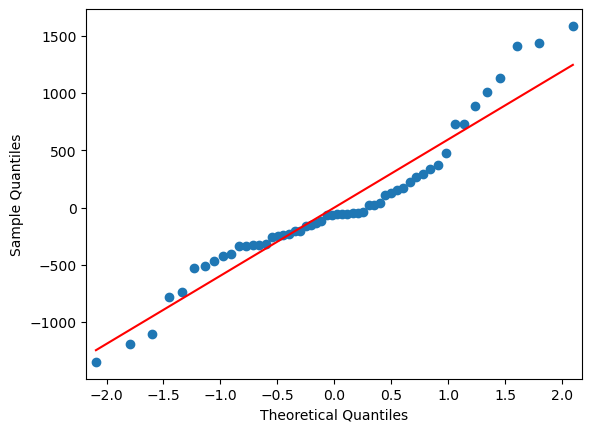

0.9369949698448181 0.006998660508543253


In [191]:
# ASSUMPTIONS CHECK.
#Check the Normal distribution of residuals
residuals = model.resid
fig = sm.qqplot(residuals, line='s')
plt.show()
fig.savefig('Residuals-service.png')

import scipy.stats as stats
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

In [210]:
final_service_time_df['batch_size'] = final_service_time_df['batch_size'].astype('float64')
final_service_time_df['epoch'] = final_service_time_df['epoch'].astype('float64')
final_service_time_df['data_parallelism'] = final_service_time_df['data_parallelism'].astype('float64')
# assumption : Homogeneity  of  variances  (variances  are  equal  between different groups) (Levene or Bartlett Test).
# batch_size * epoch * data_parallelism
import scipy.stats as stats
w, pvalue = stats.bartlett(final_service_time_df['batch_size'], final_service_time_df['epoch'], final_service_time_df['data_parallelism'])
print(w, pvalue)

621.4377563164154 1.1389529733960219e-135


In [154]:
results.round(3).to_csv('service_time_anova.csv')  

## Accuracy output

In [100]:
accuracy_df = pd.DataFrame({"batch_size": pd.Series(dtype='category'), "epoch": pd.Series(dtype='category'), "data_parallelism": pd.Series(dtype='category'), "accuracy": pd.Series(dtype='float64')})
# accuracy_df = pd.DataFrame({"batch_size": [], "epoch": [], "data_parallelism": [], "accuracy": []})
for batch_size in [64, 128, 256]:
    for r_type in glob(f'data/{batch_size}/*'):
        for log_path in glob(os.path.join(r_type,'*.log')):
            server_log_data  = open(log_path)
            acc_avg = np.array([])
            for l in server_log_data.readlines():
                if l.find('Scheduling') >=0:
                    label = l.strip().split(' ')[-1]
                    files = glob(os.path.join(r_type, '0/cloud_experiment_'+label+'/*/*/*'))
                    for file in files:
                        log_df = logs_to_pandas(file)
                        acc_df = log_df.loc[log_df['metric'] == 'accuracy per epoch']
                        acc = acc_df.iloc[-1]['value']
                        acc_avg = np.append(acc_avg, acc)
            
            if batch_size==64 or batch_size==256:
                epoch = log_path.split('/')[-1].split('.')[0].split('-')[1]
                data_parallelism = log_path.split('/')[-1].split('.')[0].split('-')[2]
                event_df = pd.DataFrame([{"batch_size": batch_size, "epoch": epoch, "data_parallelism": data_parallelism, "accuracy": np.round(np.mean(acc_avg),3)}])
            elif batch_size==128:
                epoch = log_path.split('/')[-1].split('.')[0].split('_')[2].strip('ep')
                data_parallelism = log_path.split('/')[-1].split('.')[0].split('_')[1].strip('dp')
                event_df = pd.DataFrame([{"batch_size": batch_size, "epoch": epoch, "data_parallelism": data_parallelism, "accuracy": np.round(np.mean(acc_avg),3)}])
            accuracy_df = pd.concat([accuracy_df, event_df], ignore_index=True)            

In [101]:
final_acc_df = accuracy_df.sort_values(by=['batch_size','epoch','data_parallelism'] , ascending=(True, True, True))
final_acc_df.reset_index(drop=True, inplace=True)

In [102]:
final_acc_df

,batch_size,epoch,data_parallelism,accuracy
0,64,30,2,88.222
1,64,30,3,87.561
2,64,30,4,87.310
3,64,35,2,88.535
4,64,35,3,87.541
5,64,35,4,87.465
6,64,40,2,88.598
7,64,40,3,88.269
8,64,40,4,87.750
9,128,30,2,88.562


In [192]:
a = [[0,2,3],[3,5,6]]

In [204]:
a_df = pd.DataFrame({'time': a[0],'fill': a[1]})

In [205]:
a_df['be'] = b
a_df

,time,fill,be
0,0,3,2
1,2,5,5
2,3,6,6


In [200]:
b = [2,5,6]

In [201]:
pd.DataFrame({'be':b})

,be
0,2
1,5
2,6
